## The mixed Poisson Problem
We consider the primal form of the Poisson equation:  Find $u$ satisfying

$$
\begin{align}
\nabla^2 u &= -f \quad\text{in $\Omega$} \\
   u &= u_0 \quad\text{on $\Gamma_D$}\\
   \nabla u \cdot n &= g \quad\text{on $\Gamma_N$.}
   \end{align}$$
   
We obtain the dual form by introducing a vector-valued flux $\sigma = \nabla u$.  Substituting, the problem becomes.  Find $(\sigma, u)$ satisfying

$$
\begin{align}
\sigma - \nabla u &= 0 \quad \text{in $\Omega$} \\
\nabla \cdot \sigma &= -f \quad \text{in $\Omega$} \\
u &= u_0 \quad \text{on $\Gamma_D$}\\
\sigma \cdot n &= g \quad\text{on $\Gamma \setminus \Gamma_D =: \Gamma_N$.}
\end{align}
  $$
  
For the variational formulation, we introduce a pair of function spaces, $\Sigma$ and $V$, and seek $(\sigma, u) \in \Sigma \times V$ such that:

$$
\begin{align}
\int_\Omega (\sigma \cdot \tau + \nabla \cdot \tau u)\,\text{d} x &= 
  \int_\Gamma \tau \cdot n u\,\text{d}s \quad \forall \tau \in \Sigma\\ 
\int_\Omega (\nabla\cdot\sigma)v\,\text{d} x &= - \int_\Omega f v\,\text{d}x 
\quad \forall v \in V.
\end{align}
$$

Notice how the weak condition in the primal form turns into a strong condition on the auxiliary variable $\sigma$ and the strong condition on $u$ in the primal form appears as a weak condition on $\sigma$.

For this problem we will solve with homogeneous Dirichlet (strong) conditions $u_0 = 0$ on the boundary of a rectangle domain $\Omega = [0, 2]\times[0,1]$, and will choose $f = 10\exp(-100((x-1)^2 + (y-0.5)^2))$. Later we consider a terrain following mesh.

In [1]:
import matplotlib.pyplot as plt
from firedrake import *

### 1.) Building terrain following mesh

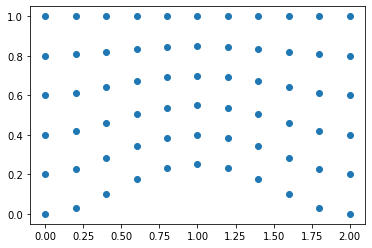

In [2]:
m = IntervalMesh(10,2)
mesh = ExtrudedMesh(m, 5, extrusion_type='uniform')

Vc = mesh.coordinates.function_space()
x, y = SpatialCoordinate(mesh)
f_mesh = Function(Vc).interpolate(as_vector([x, y + ( 0.25 * x**4 -x**3 + x**2) * (1-y) ] ) )
mesh.coordinates.assign(f_mesh)

xs = [mesh.coordinates.dat.data[i][0] for i in range(0,66)]
ys = [mesh.coordinates.dat.data[i][1] for i in range(0,66)]

plt.scatter(xs, ys)


### 2.) Defining $RT_0$ FEM space on extruded mesh

In [3]:
#define RT_0 on extruded meshes

CG_1 = FiniteElement("CG", interval, 1)
DG_0 = FiniteElement("DG", interval, 0)
P1P0 = TensorProductElement(CG_1, DG_0)
RT_horiz = HDivElement(P1P0)
P0P1 = TensorProductElement(DG_0, CG_1)
RT_vert = HDivElement(P0P1)
element = RT_horiz + RT_vert

Sigma = FunctionSpace(mesh, element)
#Sigma = FunctionSpace(mesh, "RTCF", 1)
VD = FunctionSpace(mesh, "DG", 0)

def create_RT_0_element(extr_mesh):
    CG_1 = FiniteElement("CG", interval, 1)
    DG_0 = FiniteElement("DG", interval, 0)
    P1P0 = TensorProductElement(CG_1, DG_0)
    RT_vert = HDivElement(P1P0)
    P0P1 = TensorProductElement(DG_0, CG_1)
    RT_horiz = HDivElement(P0P1)
    element = RT_horiz + RT_vert

    Sigma = FunctionSpace(mesh, element)
    
    return Sigma

### 3.) Define problem (actually Helmholtz eq.) and solve subject to $\sigma \cdot n = 0$ on the whole boundary

Text(0.5, 1.0, '$\\sigma$')

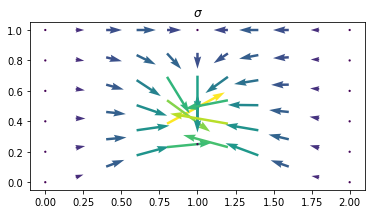

In [4]:
W = Sigma * VD

sigma, u = TrialFunctions(W)
tau, v = TestFunctions(W)

#boundary conditions_ Neumann at top and bottom for sigma=W.sub(0)
bc0 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), "bottom")
bc1 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), "top")
bc2 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), 1)
bc3 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), 2)
#force term
x, y = SpatialCoordinate(mesh)
f = 10*exp(-100*((x - 1)**2 + (y - 0.5)**2))

#set up variational problem
a = dot(sigma, tau)*dx  + div(tau)*u*dx + div(sigma)*v*dx + u*v*dx
L = -f*v*dx

#will be the solution
wh = Function(W)

#solve

parameters = {"ksp_type":"gmres", "ksp_monitor":None, 
              "pc_type":"lu", "mat_type":"aij",
              "pc_factor_mat_solver_type":"mumps" }

solve(a == L, wh, bcs=[bc0, bc1, bc2, bc3], solver_parameters=parameters)

sigmah, uh = wh.split()

#output/plot solution
file0 = File("Piola.pvd")
file0.write(sigmah, uh)

fig, axes = plt.subplots()
quiver(sigmah, axes=axes)
axes.set_aspect("equal")
axes.set_title("$\sigma$")


### Now, everything combined in one function

In [5]:
def solve_mixed_Poisson(mesh, solver_parameters, file_sol):
    Sigma = create_RT_0_element(mesh)
    V = FunctionSpace(mesh, "DG", 0)
    W = Sigma * V

    sigma, u = TrialFunctions(W)
    tau, v = TestFunctions(W)
    x, y = SpatialCoordinate(mesh)
    f = 10*exp(-100*((x - 1)**2 + (y - 0.5)**2))
    
    bc0 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), "bottom")
    bc1 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), "top")
    bc2 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), 1)
    bc3 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), 2)

    a = dot(sigma, tau)*dx + div(tau)*u*dx + div(sigma)*v*dx + v*u*dx
    L = -f*v*dx
    
    wh = Function(W)
        
    problem = LinearVariationalProblem(a, L, wh, bcs=[bc0,bc1, bc2, bc3])
    solver = LinearVariationalSolver(problem, solver_parameters=solver_parameters)
    
    #solve
    solver.solve()
    sigmah, uh = wh.split()
    
    #output to file
    file_sol.write(sigmah,uh)
    
    #plot with matplotlib
    fig, axes = plt.subplots()
    quiver(sigmah, axes=axes)
    axes.set_aspect("equal")
    axes.set_title("$\sigma$")

    return None

In [6]:
#solve and output 
#file = File("Piola.pvd")
#solve_mixed_Poisson(mesh,parameters, file)